## Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

### Dataset Attribute Information
1) id: unique identifier  
2) gender: "Male", "Female" or "Other"  
3) age: age of the patient  
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension  
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  
6) ever_married: "No" or "Yes"  
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  
8) Residence_type: "Rural" or "Urban"  
9) avg_glucose_level: average glucose level in blood  
10) bmi: body mass index  
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*  
12) stroke: 1 if the patient had a stroke or 0 if not  

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [1]:
import numpy as np
import pandas as pd
import os
import researchpy as rp
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as ss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, roc_auc_score, recall_score
from sklearn.metrics import plot_confusion_matrix

from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def get_or(contin):
    odds1 = contin.iloc[0][1]/contin.iloc[0][0]
    odds2 = contin.iloc[1][1]/contin.iloc[1][0]
    return odds2/odds1

In [3]:
path = "./data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.shape

(5110, 12)

In [6]:
# Get rid of the 'id' column
df = df.drop('id', axis=1)

In [7]:
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [8]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

So, there is 201 NaN in 'bmi' column.  
Let's see the distribution of stroke values among them.

In [9]:
nan_str_pos = round(df[df.bmi.isnull()]['stroke'].value_counts()[1] / len(df[df.bmi.isnull()]) * 100, 2)
total_str_pos = round(len(df[df['stroke']==1]) / len(df) * 100, 2)
print("Percentage of Stroke positive patients in patients whose bmi values are NaN: ", nan_str_pos, "%")
print("Percentage of Stroke positive pateints in the dataset: ", total_str_pos, "%")
print("If we drop data with missing values in 'bmi' column, then we will lose ", round(df[df.bmi.isnull()]['stroke'].value_counts()[1]/len(df[df['stroke']==1]) * 100, 2), "% of stroke positive data from the dataset")

Percentage of Stroke positive patients in patients whose bmi values are NaN:  19.9 %
Percentage of Stroke positive pateints in the dataset:  4.87 %
If we drop data with missing values in 'bmi' column, then we will lose  16.06 % of stroke positive data from the dataset


At first, I will drop rows with missing values in 'bmi' column and do the EDA.  
Then, when I build classification models to predict stroke positive patients, I will use a regression model to  
predict bmi values and use them as a true data.  
This can make the classification models faulty, but in my opinion, the dataset is imbalanced data so  
it seems reasonable to make the best use of every stroke positive patient data, even if those bmi data are predicted values.

In [10]:
# Let's make another dataframe for EDA
df1 = df.dropna()

## Explorative Data Analysis

### Numeric features

In [11]:
df[num_features].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


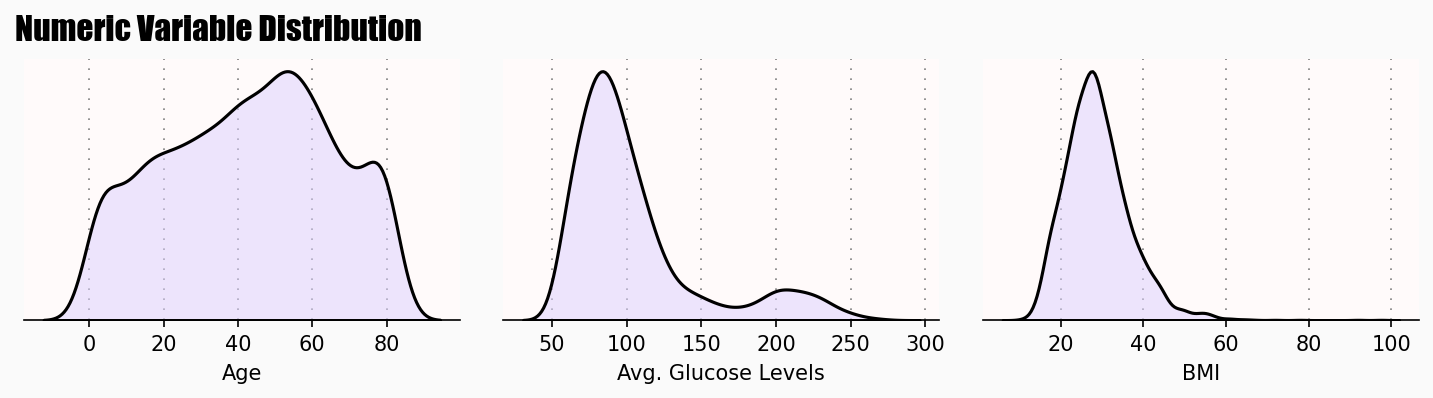

In [12]:
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = '#fffafa'

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()['ax'+str(plot)].set_facecolor(background_color)
        locals()['ax'+str(plot)].tick_params(axis='y', left=False)
        locals()['ax'+str(plot)].get_yaxis().set_visible(False)
        for s in ['top', 'right', 'left']:
            locals()['ax'+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

for variable in num_features:
    sns.kdeplot(df1[variable], ax=locals()['ax'+str(plot)], color='#dcd0ff', shade='fill', linewidth=1.5,
               ec='black', alpha=0.5, zorder=3, legend=False)
    locals()['ax'+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1, 5))
    plot += 1
    
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

ax0.text(-20, 0.018, s="Numeric Variable Distribution", fontsize=16, fontweight='bold', fontfamily='fantasy')
plt.show()

We can see a positive skew in **BMI** and **Avg. Glucose Level**.  

And **age** shows somewhat Guassian-like distribution.

See how the distribution of our numeric variables is different for those that have strokes, and those that do not.

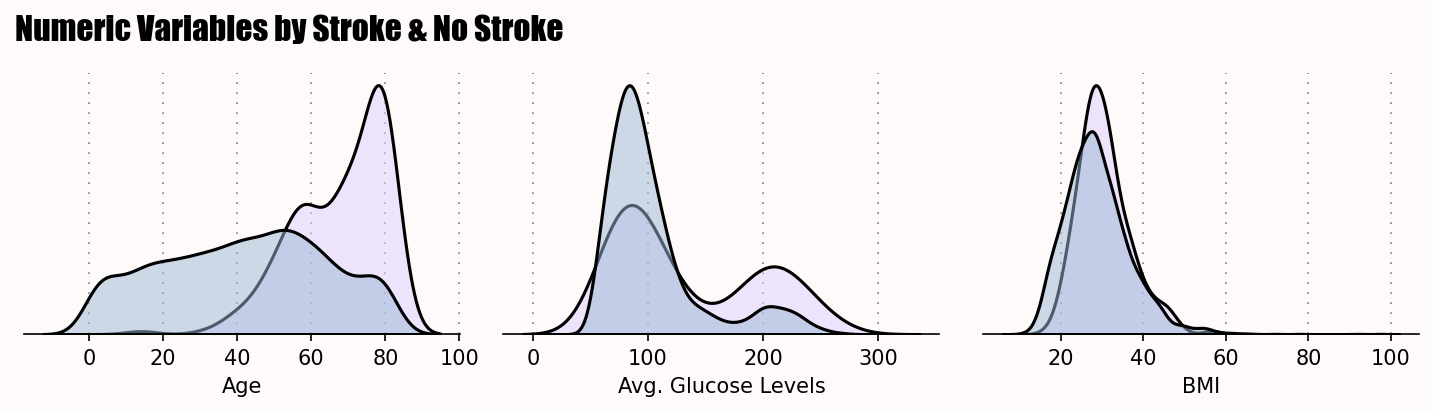

In [13]:
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fffafa')
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = '#fffafa'

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()['ax'+str(plot)].set_facecolor(background_color)
        locals()['ax'+str(plot)].tick_params(axis='y', left=False)
        locals()['ax'+str(plot)].get_yaxis().set_visible(False)
        for s in ['top', 'right', 'left']:
            locals()['ax'+str(plot)].spines[s].set_visible(False)
        plot += 1


st = df1[df1['stroke']==1]
nst = df1[df1['stroke']==0]

plot = 0
for variable in num_features:
    sns.kdeplot(st[variable], ax=locals()['ax'+str(plot)], color='#dcd0ff', shade='fill', linewidth=1.5, ec='black', alpha=0.5, 
               zorder=3, legend=False)
    sns.kdeplot(nst[variable], ax=locals()['ax'+str(plot)], color='#9bb7d4', shade='fill', linewidth=1.5, ec='black', alpha=0.5,
               zorder=3, legend=False)
    locals()['ax'+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1, 5))
    plot += 1
    
ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')

ax0.text(-20, 0.045, s="Numeric Variables by Stroke & No Stroke", fontsize=16, fontweight='bold', fontfamily='fantasy')
plt.show()

**Age** looks to be a prominent factor - this will likely be a salient feature in our models

### Categorical Features

In [14]:
rp.summary_cat(df1[cat_features])

,Variable,Outcome,Count,Percent
0,gender,Female,2897,59.01
1,,Male,2011,40.97
2,,Other,1,0.02
3,hypertension,0,4458,90.81
4,,1,451,9.19
5,heart_disease,0,4666,95.05
6,,1,243,4.95
7,ever_married,Yes,3204,65.27
8,,No,1705,34.73
9,work_type,Private,2811,57.26


There is single 'Other' value in 'gender' column.  
So drop it.

In [15]:
df1 = df1[df1.gender!='Other']

In [16]:
'gender', 'ever_married', 'work_type', 'Residence_type'
'hypertension', 'heart_disease'
'smoking_status'

'smoking_status'

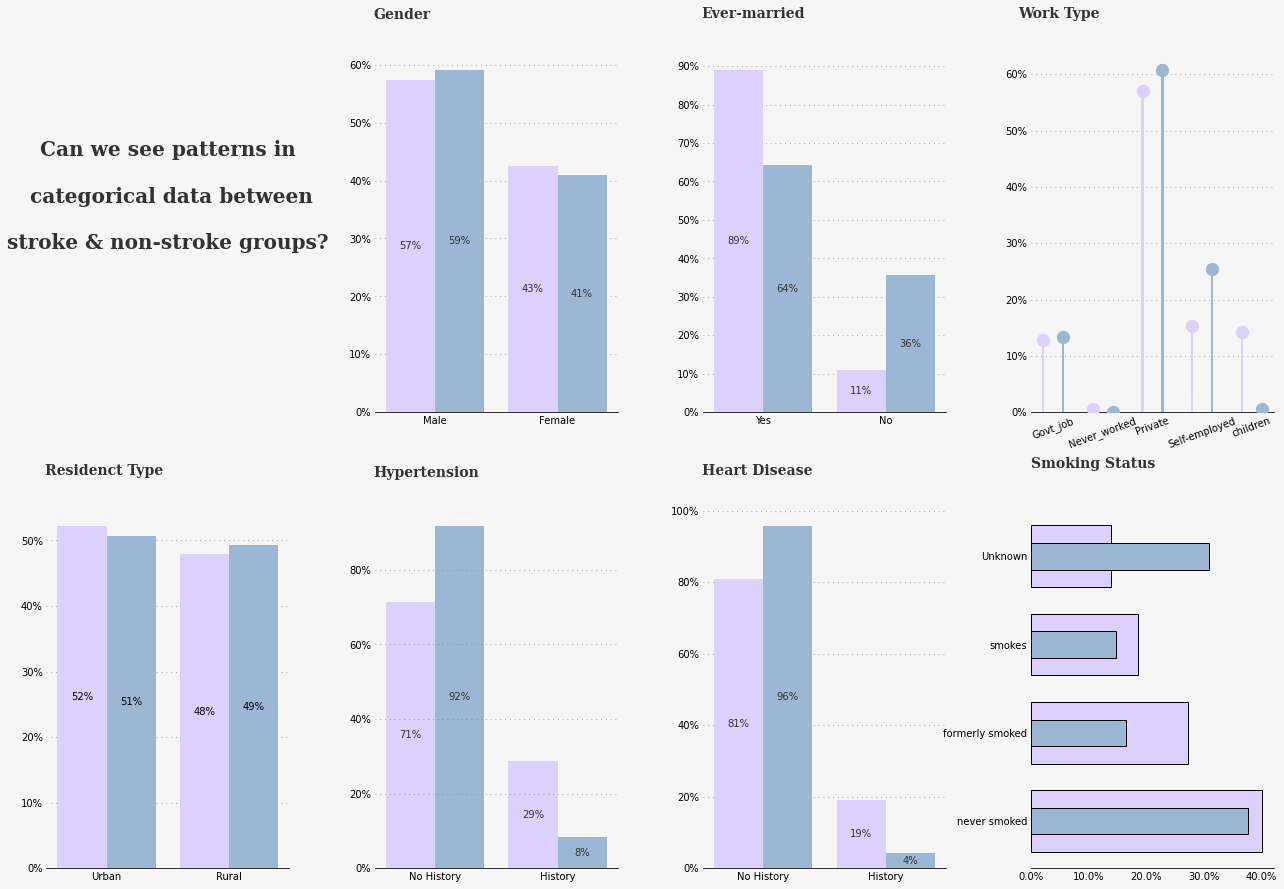

In [17]:
fig = plt.figure(figsize=(22, 15))
gs = fig.add_gridspec(2, 4)
gs.update(wspace=0.35, hspace=0.27)
plot = 0
for i in range(2):
    for j in range(4):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[i, j])
        plot += 1

background_color = '#f6f6f6'
fig.patch.set_facecolor(background_color) # figure background color

# Plots
str_only = df1[df1.stroke==1]
no_str_only = df1[df1.stroke==0]

# ax0 : Title

ax0.spines['bottom'].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5, 0.6, "Can we see patterns in\n\n categorical data between\n\nstroke & non-stroke groups?", ha='center', va='center',
        fontsize=20, fontweight='bold', fontfamily='serif', color='#323232')


# Gender

positive = pd.DataFrame(str_only.gender.value_counts())
negative = pd.DataFrame(no_str_only.gender.value_counts())
positive['Percentage'] = positive.gender.apply(lambda x: x/positive.gender.sum()*100)
negative['Percentage'] = negative.gender.apply(lambda x: x/negative.gender.sum()*100)

x = np.arange(len(positive))
ax1.bar(x, height=positive.Percentage, zorder=3, color='#dcd0ff', width=0.4)
ax1.bar(x+0.4, height=negative.Percentage, zorder=3, color='#9bb7d4', width=0.4)
ax1.set_xticks(x + 0.4 / 2)
ax1.set_xticklabels(['Male', 'Female'])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
for i, j in zip([0, 1], positive.Percentage):
    ax1.annotate(text=f"{j:0.0f}%", xy=(i, j/2), ha='center', va='center', color='#323232')
for i, j in zip([0, 1], negative.Percentage):
    ax1.annotate(text=f"{j:0.0f}%", xy=(i+0.4, j/2), ha='center', va='center', color='#323232')
ax1.text(-0.3, 68, "Gender", fontsize=14, fontweight='bold', fontfamily='serif', color='#323232')

# Ever-married

positive = pd.DataFrame(str_only.ever_married.value_counts())
positive['Percentage'] = positive.ever_married.apply(lambda x: x/positive.ever_married.sum() * 100)
negative = pd.DataFrame(no_str_only.ever_married.value_counts())
negative['Percentage'] = negative.ever_married.apply(lambda x: x/negative.ever_married.sum() * 100)
x = np.arange(len(positive))
ax2.bar(x, height=positive.Percentage, zorder=3, color='#dcd0ff', width=0.4)
ax2.bar(x+0.4, height=negative.Percentage, zorder=3, color='#9bb7d4', width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Yes', 'No'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax2.grid(axis='y', color='gray', linestyle=':', dashes=(1, 5), zorder=0)
for i, j in zip(x, positive.Percentage):
    ax2.annotate(text=f"{j:0.0f}%", xy=(i, j/2), ha='center', va='center', color='#323232')
for i, j in zip(x, negative.Percentage):
    ax2.annotate(text=f"{j:0.0f}%", xy=(i + 0.4, j/2), ha='center', va='center', color='#323232')
ax2.text(-0.3, 102.5, "Ever-married", fontfamily='serif', fontsize=14, fontweight='bold', color='#323232')


# Work Type

negative = pd.DataFrame(no_str_only.work_type.value_counts())
negative['Percentage'] = negative.work_type.apply(lambda x: x/sum(negative.work_type) * 100)
negative = negative.sort_index()

positive = pd.DataFrame(str_only.work_type.value_counts())
positive['Percentage'] = positive.work_type.apply(lambda x: x/sum(positive.work_type) * 100)

no_val_idx = [i for i in negative.index if i not in positive.index]

for idx in no_val_idx:
    positive = pd.concat([positive, pd.DataFrame([[0, 0]], columns=['Percentage', 'work_type'], index=[idx])])
positive = positive.sort_index()

ax3.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
ax3.bar(negative.index, height=negative.Percentage, zorder=3, color='#dcd0ff', width=0.05)
ax3.scatter(negative.index, negative.Percentage, zorder=3, s=150, color='#dcd0ff')
ax3.bar(np.arange(len(positive.index))+0.4, height=positive.Percentage, zorder=3, color='#9bb7d4', width=0.05)
ax3.scatter(np.arange(len(positive.index))+0.4, y=positive.Percentage, zorder=3, s=150, color='#9bb7d4')

ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax3.set_xticks(np.arange(len(positive.index))+0.2)
ax3.tick_params(axis='x', rotation=20)
ax3.text(-0.5, 70, "Work Type", fontfamily='serif', fontsize=14, fontweight='bold', color='#323232')


# Residence type

positive = pd.DataFrame(str_only.Residence_type.value_counts())
negative = pd.DataFrame(no_str_only.Residence_type.value_counts())
positive['Percentage'] = positive.Residence_type.apply(lambda x: x/positive.Residence_type.sum() * 100)
negative['Percentage'] = negative.Residence_type.apply(lambda x: x/negative.Residence_type.sum() * 100)

x = np.arange(len(positive))
ax4.grid(axis='y', color='gray', linestyle=':', zorder=0, dashes=(1, 5))
ax4.bar(x, height=positive.Percentage, zorder=3, width=0.4, color='#dcd0ff')
ax4.bar(x+0.4, height=negative.Percentage, zorder=3, width=0.4, color='#9bb7d4')
ax4.yaxis.set_major_formatter(mtick.PercentFormatter())
ax4.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax4.set_xticks(x + 0.4 / 2)
ax4.set_xticklabels(['Urban', 'Rural'])
for i, j in zip(x, positive.Percentage):
    ax4.annotate(f"{j:0.0f}%", xy=(i, j/2), color='black', ha='center', va='center')
for i, j in zip(x, negative.Percentage):
    ax4.annotate(f"{j:0.0f}%", xy=(i+0.4, j/2), color='black', ha='center', va='center')
ax4.text(-0.3, 60, "Residenct Type", fontfamily='serif', fontsize=14, fontweight='bold', color='#323232')

# hypertension

positive = pd.DataFrame(str_only.hypertension.value_counts())
positive['Percentage'] = positive.hypertension.apply(lambda x: x/sum(positive.hypertension) * 100)
negative = pd.DataFrame(no_str_only.hypertension.value_counts())
negative['Percentage'] = negative.hypertension.apply(lambda x: x/sum(negative.hypertension) * 100)

x = np.arange(len(positive))
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
ax5.bar(x, positive.Percentage, width=0.4, color='#dcd0ff')
ax5.bar(x+0.4, negative.Percentage, width=0.4, color='#9bb7d4')
ax5.set_xticks(x + 0.4 / 2)
ax5.set_xticklabels(['No History', 'History'])
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.yaxis.set_major_locator(mtick.MultipleLocator(20))

for i, j in zip(x, positive.Percentage):
    ax5.annotate(f'{j:0.0f}%', xy=(i, j/2), color='#323232', ha='center', va='center')
for i, j in zip(x + 0.4, negative.Percentage):
    ax5.annotate(f"{j:0.0f}%", xy=(i, j/2), color='#323232', ha='center', va='center')

ax5.text(-0.3, 105, "Hypertension", fontfamily='serif', fontweight='bold', fontsize=14, color='#323232')
    

# Heart Disease

positive = pd.DataFrame(str_only.heart_disease.value_counts())
positive['Percentage'] = positive.heart_disease.apply(lambda x: x/positive.heart_disease.sum()*100)
negative = pd.DataFrame(no_str_only.heart_disease.value_counts())
negative['Percentage'] = negative.heart_disease.apply(lambda x: x/negative.heart_disease.sum()*100)

x = np.arange(len(positive))
ax6.bar(x, height=positive.Percentage, zorder=3, color='#dcd0ff', width=0.4)
ax6.bar(x+0.4, height=negative.Percentage, zorder=3, color='#9bb7d4', width=0.4)
ax6.set_xticks(x + 0.4 / 2)
ax6.set_xticklabels(['No History', 'History'])
ax6.grid(color='gray', axis='y', linestyle=':', zorder=0, dashes=(1, 5))
ax6.yaxis.set_major_formatter(mtick.PercentFormatter())
ax6.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i, j in zip([0, 1], positive.Percentage):
    ax6.annotate(text=f"{j:0.0f}%", xy=(i, j/2), ha='center', va='center', color='#323232')
for i, j in zip([0, 1], negative.Percentage):
    ax6.annotate(text=f"{j:0.0f}%", xy=(i+0.4, j/2), ha='center', va='center', color='#323232')
ax6.text(-0.3, 110, "Heart Disease", fontsize=14, fontfamily='serif', fontweight='bold', color='#323232')
    

# Smoking
positive = pd.DataFrame(str_only.smoking_status.value_counts())
negative = pd.DataFrame(no_str_only.smoking_status.value_counts())
positive['Percentage'] = positive.smoking_status.apply(lambda x: x/positive.smoking_status.sum()*100)
negative['Percentage'] = negative.smoking_status.apply(lambda x: x/negative.smoking_status.sum()*100)

ax7.barh(positive.index, positive.Percentage, color='#dcd0ff', ec='black', zorder=3, height=0.7)
ax7.barh(negative.index, negative.Percentage, color='#9bb7d4', zorder=3, ec='black', height=0.3)
ax7.xaxis.set_major_formatter(mtick.PercentFormatter())
ax7.xaxis.set_major_locator(mtick.MultipleLocator(10))

ax7.text(0, 4, "Smoking Status", fontsize=14, fontweight='bold', fontfamily='serif', color='#323232')

for s in ['top', 'right', 'left']:
    for i in range(0, 8):
        locals()['ax'+str(i)].spines[s].set_visible(False)
        locals()['ax'+str(i)].set_facecolor(background_color)
        locals()['ax'+str(i)].tick_params(length=0)
    
plt.show()

**Ever_married** column data show there is difference in ratio between stroke and non-stroke group.  
**Hypertension** and **Heart Disease** column data also show differences in ratio between stroke and non-stroke group and it seems the bar plots of two features quite resemble.  
**Smoking status** column data show that there are more stroke positive patients in formerly-smoked and currently-smokes groups.

### Make new features

**age bins**

In [18]:
df['age_bin'] = pd.cut(x=df.age, bins=[0, 10, 20, 40, 60, 80, 100], labels=['0-10', '10-20', '20-40', '40-60', '60-80', '80-100'])

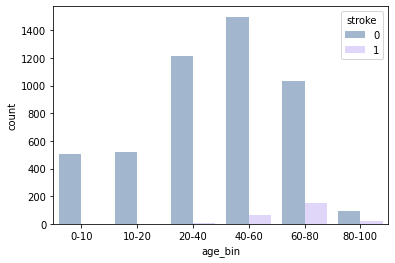

In [19]:
sns.countplot('age_bin', hue='stroke', data=df, palette=['#9bb7d4', '#dcd0ff']);

**bmi groups**

In [20]:
df.bmi.mean()

28.893236911794666

As the mean value of BMI is 28.9 and BMI over or equal to 30 is considered as obese,  
I decided to split BMI data into 2 groups(less than 30 (not obese) and over or equal to 30(obese)).

In [21]:
bmi_map = lambda x: 1 if x>=30 else 0
df['bmi_group'] = df.bmi.apply(bmi_map)

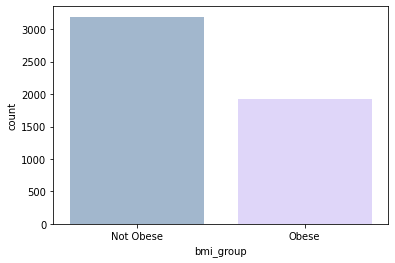

In [22]:
sns.countplot(df.bmi_group, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks(ticks=[0, 1], labels=['Not Obese', 'Obese']);

**glucose groups**

It is considered as suggestive of type 2 diabetes when random blood sugar test result shows  
blood sugar level of 200 milligrams per deciliter (mg/dL) or higher.

In [23]:
glc_map = lambda x: 1 if x>=200 else 0
df['glc_group'] = df.avg_glucose_level.apply(glc_map)

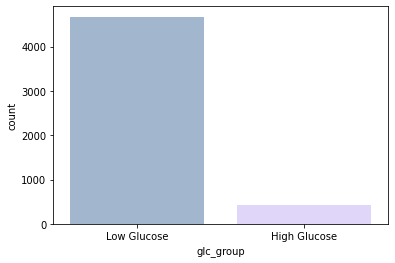

In [24]:
sns.countplot(df.glc_group, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks(ticks=[0, 1], labels=['Low Glucose', 'High Glucose']);

### Data cleaning and using RandomForestRegressor to predict the missing values in BMI column

In [25]:
data = df.copy()

In [26]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_bin                0
bmi_group              0
glc_group              0
dtype: int64

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [28]:
le = LabelEncoder()

In [29]:
data = data[data.gender != 'Other'].reset_index(drop=True)
data.gender = data.gender.map({'Male': 0, 'Female': 1}).astype('int')
data.ever_married = data.ever_married.map({'Yes': 1, 'No': 0}).astype('int')
data.Residence_type = data.Residence_type.map({'Urban': 1, 'Rural': 0}).astype('int')
data.work_type = le.fit_transform(data.work_type)
data.smoking_status = data.smoking_status.map({'never smoked':0, 'formerly smoked':1, 'smokes':2, 'Unknown':3}).astype('int')
data.age_bin = le.fit_transform(data.age_bin)

In [30]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,bmi_group,glc_group
0,0,67.0,0,1,1,2,1,228.69,36.6,1,1,4,1,1
1,1,61.0,0,0,1,3,0,202.21,NaN,0,1,4,0,1
2,0,80.0,0,1,1,2,0,105.92,32.5,0,1,4,1,0
3,1,49.0,0,0,1,2,1,171.23,34.4,2,1,3,1,0
4,1,79.0,1,0,1,3,0,174.12,24.0,0,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,1,80.0,1,0,1,2,1,83.75,NaN,0,0,4,0,0
5105,1,81.0,0,0,1,3,1,125.20,40.0,0,0,5,1,0
5106,1,35.0,0,0,1,3,0,82.99,30.6,0,0,2,1,0
5107,0,51.0,0,0,1,2,0,166.29,25.6,1,0,3,0,0


In [31]:
missing = data[data.bmi.isnull()].drop('bmi', axis=1)
X = data[~data.bmi.isnull()].drop('bmi', axis=1)
y = data.bmi[~data.bmi.isnull()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# n_estimators = [75, 100, 125, 150, 200]
# max_features = [2, 4, 6, 8, 10]
# bootstrap = [True, False]
# max_depth = [2, 4, 6, 8, 10, None]
# param_grid = {'n_estimators': n_estimators,
#              'max_features': max_features,
#              'bootstrap': bootstrap,
#              'max_depth': max_depth}

# rfr = RandomForestRegressor()
# gscv_rfr = GridSearchCV(rfr, param_grid)
# gscv_rfr.fit(X_train, y_train)
# gscv_rfr.best_params_
## {'bootstrap': True, 'max_depth': 6, 'max_features': 6, 'n_estimators': 150}

In [33]:
best_rfr_bmi_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('reg', RandomForestRegressor(bootstrap=True, max_depth=6, max_features=6,
                                                                n_estimators=150, random_state=42))])

In [34]:
best_rfr_bmi_pipeline.fit(X, y)
pred = best_rfr_bmi_pipeline.predict(missing)

In [35]:
data.bmi[data.bmi.isnull()] = pred

In [36]:
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,bmi_group,glc_group
0,0,67.0,0,1,1,2,1,228.69,36.600000,1,1,4,1,1
1,1,61.0,0,0,1,3,0,202.21,26.551778,0,1,4,0,1
2,0,80.0,0,1,1,2,0,105.92,32.500000,0,1,4,1,0
3,1,49.0,0,0,1,2,1,171.23,34.400000,2,1,3,1,0
4,1,79.0,1,0,1,3,0,174.12,24.000000,0,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,1,80.0,1,0,1,2,1,83.75,25.333429,0,0,4,0,0
5105,1,81.0,0,0,1,3,1,125.20,40.000000,0,0,5,1,0
5106,1,35.0,0,0,1,3,0,82.99,30.600000,0,0,2,1,0
5107,0,51.0,0,0,1,2,0,166.29,25.600000,1,0,3,0,0


## Questions
We've explored the data and cleaned the data.  
Now, we have to make some questions about the data and find answer of those questions from the data.

These are my questions after a brief EDA.

1. Is there a difference in demographic features between stroke vs non-stroke group?
2. Underlying diseases can affect the incidence of stroke?
3. Lifestyle modification can be a effective way to prevent stroke?

### Question 1

Demographics are the classifiable characteristics of a given population.  
Demographic data refers to socioeconomic information expressed statistically, including employment, education, income, marriage rates, birth and death rates, and more.  
  
In our dataset, we have 'gender', 'age', 'ever_married', 'work_type', 'Residence_type'.  
  
Let's look at those data.

### gender

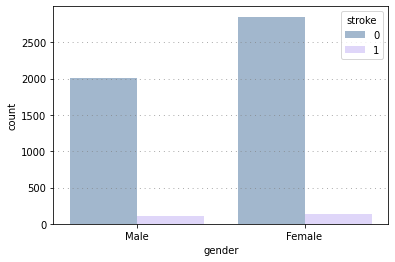

In [37]:
sns.countplot(x='gender', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.grid(axis='y', color='gray', linestyle=':', dashes=(1, 5));

In [38]:
print('Percentage of Male Stroke patient among Male group: ', round(((data.gender==0)&(data.stroke==1)).sum()/(data.gender==0).sum() * 100, 2), '%')
print('Percentage of Female Stroke patient among Male group: ', round(((data.gender==1)&(data.stroke==1)).sum()/(data.gender==1).sum() * 100, 2), '%')

Percentage of Male Stroke patient among Male group:  5.11 %
Percentage of Female Stroke patient among Male group:  4.71 %


Let's compare ratio of stroke patient among gender groups with contingency table and chi-square test.

In [39]:
contin = pd.crosstab(data.gender, data.stroke)
contin

stroke,0,1
gender,,
0,2007,108
1,2853,141


In [40]:
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,0.340003,0.559828,1


p-value is higher than 0.05 and it indicates strong evidence for the null hypothesis  
which is there is no significant difference of stroke patient proportions between gender groups.

### age

<AxesSubplot:xlabel='age', ylabel='Density'>

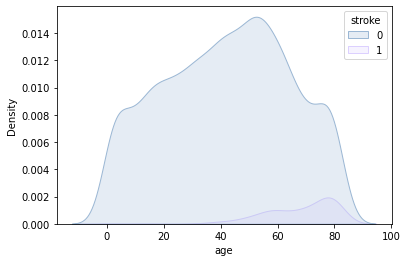

In [41]:
sns.kdeplot(x='age', data=data, hue='stroke', shade=True, palette=['#9bb7d4', '#dcd0ff'])

In [42]:
print('Mean of age values in stroke positive group : ', round(data.age[data.stroke==1].mean(), 2))
print('Mean of age values in stroke positive group : ', round(data.age[data.stroke==0].mean(), 2))

Mean of age values in stroke positive group :  67.73
Mean of age values in stroke positive group :  41.97


In [43]:
result = ss.levene(data.age[data.stroke==1], data.age[data.stroke==0], center='median')

if result.pvalue < 0.05:
    print(f"Brown-Forsythe test : statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    print("Data satisfy equality of variance assumption.")
else : 
    print(f"Brown-Forsythe test : statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    print("Data does not satisfy equality of variance assumption.")

Brown-Forsythe test : statistic = 129.7214, p-value = 0.0000
Data satisfy equality of variance assumption.


So above data satisfy equality of variance assumption, now we can use independent t-test to compare the averages of ages between stroke and non-stroke group.

In [44]:
ss.ttest_ind(data.age[data.stroke==1], data.age[data.stroke==0])

Ttest_indResult(statistic=18.07760628336985, pvalue=7.435468822639662e-71)

p-value is way lower than 0.05 and it indicates strong evidence for the alternative hypothesis
which is there is a significant difference in averages of ages between stroke and non-stroke groups.  
  
This result correlates with what we've already seen in the EDA.

### marriage

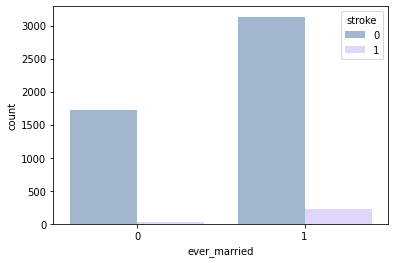

In [45]:
sns.countplot(x='ever_married', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff']);

In [46]:
print('Percentage of Stroke patient who ever married among ever-married group: ', round(((df.ever_married=='Yes')&(df.stroke==1)).sum()/(df.ever_married=='Yes').sum() * 100, 2), '%')
print('Percentage of Stroke patient who have never married among never-married group: ', round(((df.ever_married=='No')&(df.stroke==1)).sum()/(df.ever_married=='No').sum() * 100, 2), '%')

Percentage of Stroke patient who ever married among ever-married group:  6.56 %
Percentage of Stroke patient who have never married among never-married group:  1.65 %


In [47]:
contin = pd.crosstab(df.ever_married, df.stroke)
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,58.92389,1.638902e-14,1


This is funny.  
As we can see in the above plot, in ever-married group the ratio of stroke patients seems to be higher than the other.  
And there is significant difference in proportion of stroke patients between marital status groups.  
**(Marriage can be tough!)**

Additionally, let's find out the odds ratio.

In [48]:
def get_or(contin):
    odds1 = contin.iloc[0][1]/contin.iloc[0][0]
    odds2 = contin.iloc[1][1]/contin.iloc[1][0]
    return round(odds2/odds1, 2)

In [49]:
get_or(contin)

4.18

The odds ratio is 4.18 and it means that odds of developing a stroke in ever-married group is 4.18 times higher than  
odds of developing stroke in never-married group.  

### residence_type

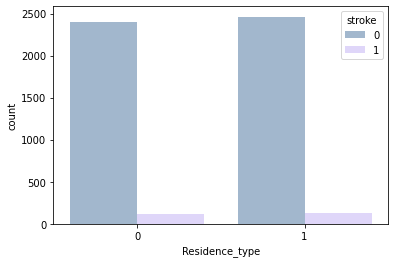

In [50]:
sns.countplot(x='Residence_type', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff']);

In [51]:
print('Percentage of Stroke patient who live in urban areas: ', round(((df.Residence_type=='Urban')&(df.stroke==1)).sum()/(df.Residence_type=='Urban').sum() * 100, 2), '%')
print('Percentage of Stroke patient who live in rural areas: ', round(((df.Residence_type=='Rural')&(df.stroke==1)).sum()/(df.Residence_type=='Rural').sum() * 100, 2), '%')

Percentage of Stroke patient who live in urban areas:  5.2 %
Percentage of Stroke patient who live in rural areas:  4.53 %


In [52]:
contin = pd.crosstab(df.Residence_type, df.stroke)
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,1.081637,0.298332,1


There is no significant difference in proportion of stroke patient between the two residence types.

### work_type

In [53]:
(df.work_type=='Never_worked').sum()

22

In [54]:
for wt in df.work_type.unique():
    print(f'{wt}', round(len(df[(df.work_type==wt)&(df.stroke==1)])/(df.work_type==wt).sum() * 100, 2), '%')

Private 5.09 %
Self-employed 7.94 %
Govt_job 5.02 %
children 0.29 %
Never_worked 0.0 %


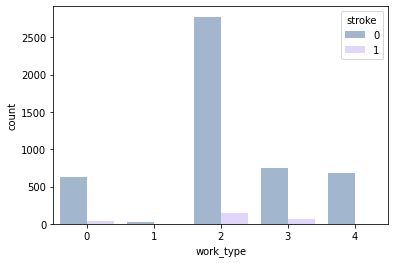

In [55]:
sns.countplot(x='work_type', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff']);

In [56]:
contin = pd.crosstab(df.work_type, df.stroke)
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,49.163512,5.397708e-10,4


: self_employed group showed slightly higher stroke incident rate than other groups.  
no stroke in never-worked group, but total number of the group was 22

#### Answer to question 1

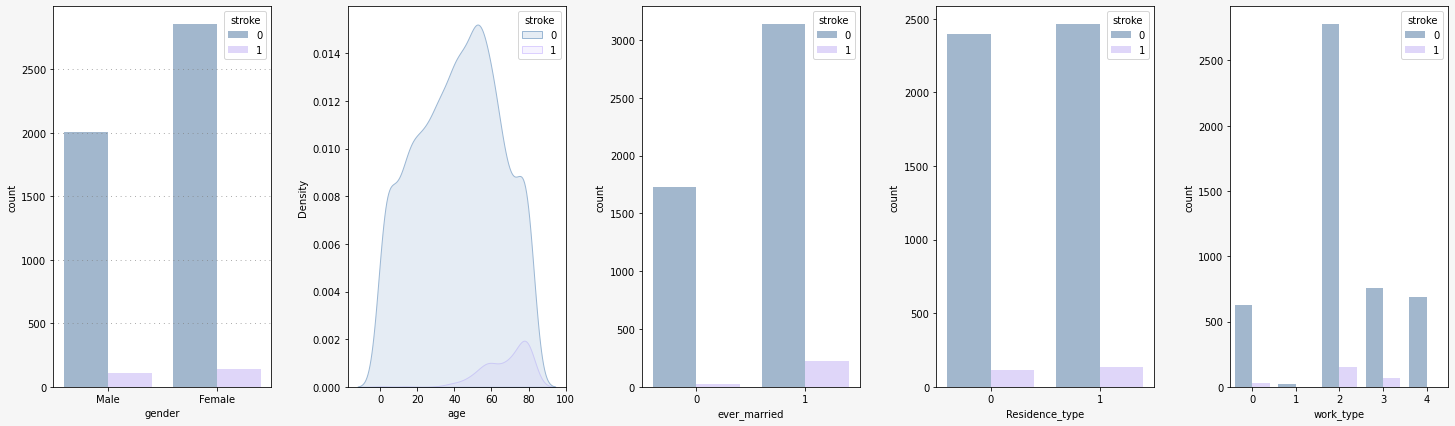

In [57]:
fig = plt.figure(figsize=(25, 7))
gs = fig.add_gridspec(1, 5)
gs.update(wspace=0.35, hspace=0.27)
plot = 0
for i in range(1):
    for j in range(5):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[i, j])
        plot += 1

background_color = '#f6f6f6'
fig.patch.set_facecolor(background_color) # figure background color

sns.countplot(x='gender', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax0)
ax0.set_xticks(ticks=[0, 1])
ax0.set_xticklabels(['Male', 'Female'])
ax0.grid(axis='y', color='gray', linestyle=':', dashes=(1, 5));

sns.kdeplot(x='age', data=data, hue='stroke', shade=True, palette=['#9bb7d4', '#dcd0ff'], ax=ax1)

sns.countplot(x='ever_married', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax2);

sns.countplot(x='Residence_type', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax3);

sns.countplot(x='work_type', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax4);

In this dataset, age seems to be the most important factor among the demographic features.  
And marital status is also a statistically significant risk factor for developing a stroke.

### Question 2

In this dataset, 'hypertension', 'heart disease', and 'average glucose level' are features related to the underlying disease.  
We will have a close look into 'hypertension', 'heart disease' and 'glucose group'.

#### hypertension

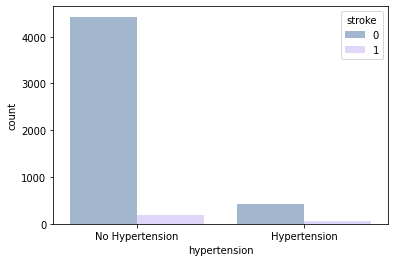

In [58]:
sns.countplot(x='hypertension', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks([0, 1], ['No Hypertension', 'Hypertension']);

In [59]:
contin = pd.crosstab(data.hypertension, data.stroke)
contin

stroke,0,1
hypertension,,
0,4428,183
1,432,66


In [60]:
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,81.573145,1.688936e-19,1


The hypertension groups are not independent of the stroke groups.  
This means subjects with hypertension have higher prevalence of stroke.

In [61]:
get_or(contin)

3.7

And its odds ratio is 3.7, which means the odds of developing a stroke in hypertension positive group is 3.7 times higher  
than the odds of developing stroke in hypertension negative group.

#### heart disease

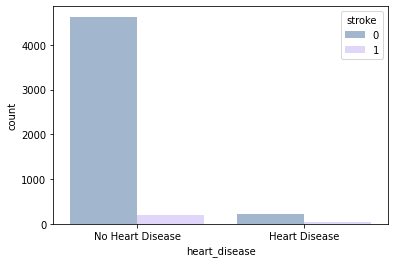

In [62]:
sns.countplot(x='heart_disease', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease']);

In [63]:
contin = pd.crosstab(data.heart_disease, data.stroke)
contin

stroke,0,1
heart_disease,,
0,4631,202
1,229,47


In [64]:
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,90.229437,2.120831e-21,1


The heart disease groups are not independent with the stroke groups.  
Subjects with heart diseases have higher prevalence of stroke.

In [65]:
get_or(contin)

4.71

And its odds ratio is 4.71, which means the odds of developing a stroke in heart disease positive group is 4.71 times higher
than the odds of developing stroke in heart disease negative group.

#### glucose group

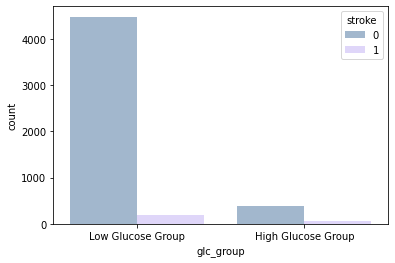

In [66]:
sns.countplot(x='glc_group', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks([0, 1], ['Low Glucose Group', 'High Glucose Group']);

In [67]:
contin = pd.crosstab(data.glc_group, data.stroke)
contin

stroke,0,1
glc_group,,
0,4482,193
1,378,56


In [68]:
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,64.076904,1.196561e-15,1


The glucose groups are not indpendent of the stroke groups.  
Subjects with high average glucose level have higher prevalence of stroke.

In [69]:
get_or(contin)

3.44

And its odds ratio is 3.44, which means the odds of developing a stroke in high glucose group is 3.44 times higher than the odds of developing stroke in low glucose group.

#### Answer to question 2

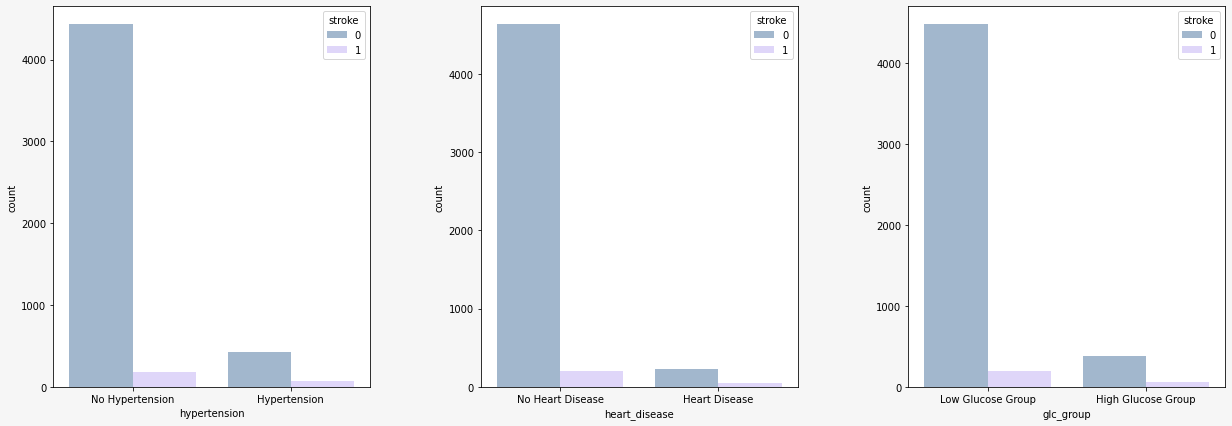

In [70]:
fig = plt.figure(figsize=(21, 7))
gs = fig.add_gridspec(1, 3)
gs.update(wspace=0.35, hspace=0.27)
plot = 0
for i in range(1):
    for j in range(3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[i, j])
        plot += 1

background_color = '#f6f6f6'
fig.patch.set_facecolor(background_color) # figure background color

sns.countplot(x='hypertension', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax0)
ax0.set_xticks([0, 1])
ax0.set_xticklabels(['No Hypertension', 'Hypertension']);

sns.countplot(x='heart_disease', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax1)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['No Heart Disease', 'Heart Disease']);

sns.countplot(x='glc_group', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax2)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Low Glucose Group', 'High Glucose Group']);

Hypertension, heart disease and glucose group can be a risk factor for developing stroke.

### Question 3

Smoking status and BMI can be modified by effort.  
If there is a relation between these factors and stroke, then it is for sure we have to make an effort to a better way to prevent stroke.

#### BMI

<AxesSubplot:xlabel='bmi', ylabel='Density'>

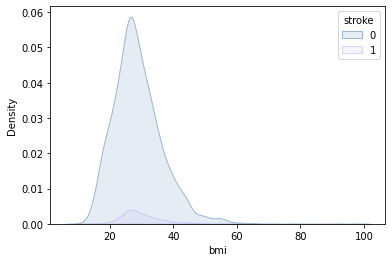

In [71]:
sns.kdeplot(x='bmi', hue='stroke', data=data, shade=True, palette=['#9bb7d4', '#dcd0ff'])

In [72]:
print('Mean of BMI values in stroke group : ', round(data.bmi[data.stroke==1].mean(), 2))
print('Mean of BMI values in non-stroke group : ', round(data.bmi[data.stroke==0].mean(), 2))

Mean of BMI values in stroke group :  29.72
Mean of BMI values in non-stroke group :  28.71


In [73]:
result = ss.levene(data.bmi[data.stroke==1], data.bmi[data.stroke==0], center='median')

if result.pvalue < 0.05:
    print(f"Brown-Forsythe test : statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    print("Data satisfy equality of variance assumption.")
else : 
    print(f"Brown-Forsythe test : statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    print("Data does not satisfy equality of variance assumption.")

Brown-Forsythe test : statistic = 16.1370, p-value = 0.0001
Data satisfy equality of variance assumption.


In [74]:
ss.ttest_ind(data.bmi[data.stroke==1], data.bmi[data.stroke==0])

Ttest_indResult(statistic=2.011774179581776, pvalue=0.04429617259366043)

p-value is lower than 0.05, so there is a statistically significant difference in the mean values of bmi between stroke and non-stroke groups.  
But if we look at the above plot, this statistical significance is not quite acceptable.  
As saying goes, obesity is a risk factor of stroke development.  
But in this dataset, maybe because of its relatively small sample sizes, imbalance and filling up missing values in bmi using predicted values by regression model, it is difficult to say there is a relation between BMI and stroke.

#### bmi group

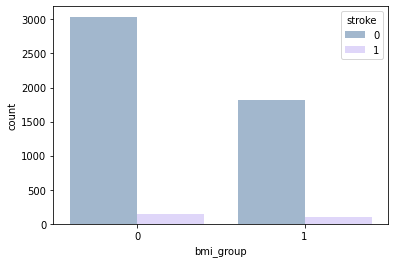

In [75]:
sns.countplot(x='bmi_group', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff']);

In [76]:
print("Percentage of stroke patient in low BMI group : ", round(((data.bmi_group==0)&(data.stroke==1)).sum()/(data.bmi_group==0).sum() * 100, 2), "%")
print("Percentage of stroke patient in high BMI group : ", round(((data.bmi_group==1)&(data.stroke==1)).sum()/(data.bmi_group==1).sum() * 100, 2), "%")

Percentage of stroke patient in low BMI group :  4.74 %
Percentage of stroke patient in high BMI group :  5.1 %


In [77]:
contin = pd.crosstab(data.bmi_group, data.stroke)
contin

stroke,0,1
bmi_group,,
0,3038,151
1,1822,98


In [78]:
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,0.277118,0.598596,1


The bmi groups are independent of the stroke groups.  
Which means there is no difference in proportion of stroke patient in BMI groups.  
In my opinion, with the same reasons I mentioned above, it is difficult to conclude BMI is not related to stroke development.

#### smoking status

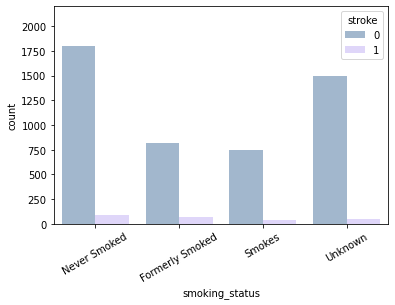

In [79]:
sns.countplot(x='smoking_status', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'])
plt.xticks([0, 1, 2, 3], ['Never Smoked', 'Formerly Smoked', 'Smokes', 'Unknown'], rotation=30)
plt.ylim(0, 2200);

In [80]:
print("Percentage of stroke patients in Never-smoked group", round(len(data[(data.stroke==1)&(data.smoking_status==0)])/len(data[data.smoking_status==0]) * 100, 2), "%")
print("Percentage of stroke patients in Formerly-smoked group", round(len(data[(data.stroke==1)&(data.smoking_status==1)])/len(data[data.smoking_status==1]) * 100, 2), "%")
print("Percentage of stroke patients in Currently-smokes group", round(len(data[(data.stroke==1)&(data.smoking_status==2)])/len(data[data.smoking_status==2]) * 100, 2), "%")
print("Percentage of stroke patients in Unknown group", round(len(data[(data.stroke==1)&(data.smoking_status==3)])/len(data[data.smoking_status==3]) * 100, 2), "%")

Percentage of stroke patients in Never-smoked group 4.76 %
Percentage of stroke patients in Formerly-smoked group 7.92 %
Percentage of stroke patients in Currently-smokes group 5.32 %
Percentage of stroke patients in Unknown group 3.04 %


In [81]:
contin = pd.crosstab(data.smoking_status, data.stroke, )
contin

stroke,0,1
smoking_status,,
0,1802,90
1,814,70
2,747,42
3,1497,47


In [82]:
col_names = ['chi2', 'p', 'dof']
chi2, p, dof, expected = ss.chi2_contingency(contin)
pd.DataFrame([[chi2, p, dof]], columns=col_names)

,chi2,p,dof
0,29.225727,0.000002,3


So the p-value is way lower than 0.05, there are differences in the proportion of stroke patients among the smoking status groups.  
But we don't know which one is different from the others.

So let's have a look at each combinations of smoking status.

In [83]:
from itertools import combinations
combi = list(combinations([0, 1, 2, 3], 2))
col_names = ['Feature_1', 'Percentage_1', 'Feature_2', 'Percentage_2', 'chi2', 'p', 'dof']
status = ['Never Smoked', 'Formerly Smoked', 'Smokes', 'Unknown']
res_df = pd.DataFrame()
for i in range(len(combi)):
    idx_1 = combi[i][0]
    idx_2 = combi[i][1]
    ct = contin.iloc[[combi[i][0], combi[i][1]]]
    chi2, p, dof, expected = ss.chi2_contingency(ct)
    df = pd.DataFrame([[status[idx_1], round(len(data[(data.stroke==1)&(data.smoking_status==idx_1)])/len(data[data.smoking_status==idx_1]) * 100, 2),
                        status[idx_2], round(len(data[(data.stroke==1)&(data.smoking_status==idx_2)])/len(data[data.smoking_status==idx_2]) * 100, 2),
                        chi2, p, dof]], columns=col_names)
    res_df = pd.concat([res_df, df], ignore_index=True)

In [111]:
import dataframe_image as dfi

In [112]:
dfi.export(res_df, 'smoking_stats.png')

In [85]:
res_df[res_df.p<0.05]

,Feature_1,Percentage_1,Feature_2,Percentage_2,chi2,p,dof
0,Never Smoked,4.76,Formerly Smoked,7.92,10.513997,1.184737e-03,1
2,Never Smoked,4.76,Unknown,3.04,6.075748,1.370503e-02,1
3,Formerly Smoked,7.92,Smokes,5.32,4.089819,4.314227e-02,1
4,Formerly Smoked,7.92,Unknown,3.04,28.069138,1.170578e-07,1
5,Smokes,5.32,Unknown,3.04,6.784094,9.197369e-03,1


Formerly smoked group and Never smoked group has statistically significant difference in the proportion of stroke patients.  
But in this dataset, currently smoking group showed lower proportion of stroke patients than formerly smoked group.  
Unknown group has lowest proportion of stroke patients.  
In my opinion, though there is a statistically significant difference in the proportion of stroke patients between currently stmoking and formerly smoked group, there is a increasing trend in stroke positive proportion toward currently smoking or formerly smoked group.  
Total number of dataset is quite low so it might not reflect the reality.

#### Answer to question 3

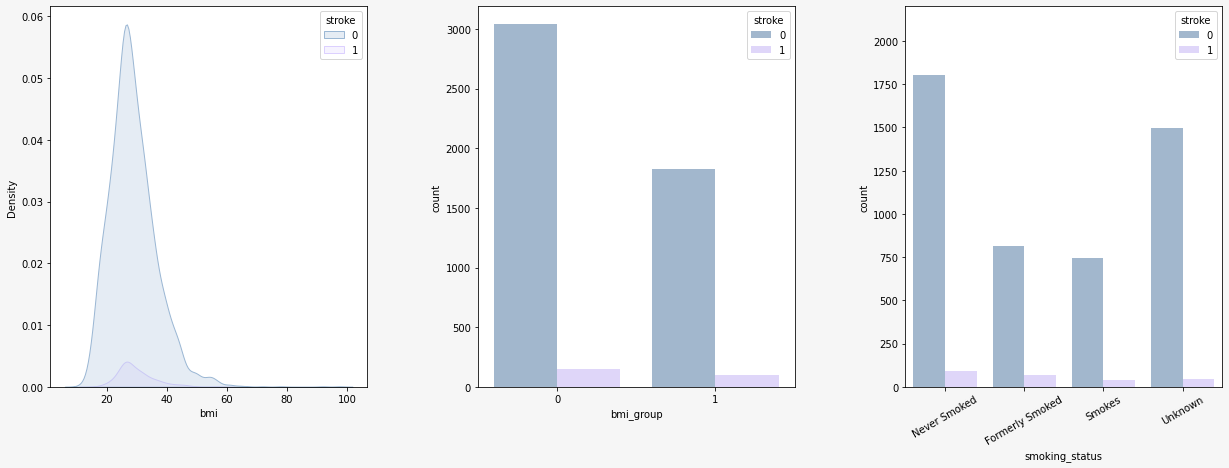

In [108]:
fig = plt.figure(figsize=(21, 7))
gs = fig.add_gridspec(1, 3)
gs.update(wspace=0.35, hspace=0.27)
plot = 0
for i in range(1):
    for j in range(3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[i, j])
        plot += 1

background_color = '#f6f6f6'
fig.patch.set_facecolor(background_color) # figure background color

sns.kdeplot(x='bmi', hue='stroke', data=data, shade=True, palette=['#9bb7d4', '#dcd0ff'], ax=ax0)

sns.countplot(x='bmi_group', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax1);

sns.countplot(x='smoking_status', hue='stroke', data=data, palette=['#9bb7d4', '#dcd0ff'], ax=ax2)
ax2.set_xticks([0, 1, 2, 3])
ax2.set_xticklabels(['Never Smoked', 'Formerly Smoked', 'Smokes', 'Unknown'], rotation=30)
ax2.set_ylim(0, 2200);

In this dataset, smoking status can be a risk factor for stroke development.  
Though former smoked group has the highest proportion of stroke patients, it seems there's a trend that the proportion of stroke patients increases in people whoever smoked.  
BMI does not seem to be a risk factor for stroke, as opposed to common knowledges.  
There might be a limitation of this dataset due to small sample size.

### Classification model

Let's make a simple classification model to predict stroke patient from this dataset.

This dataset is an imbalanced dataset so,  
I'll use **SMOTE(Synthetic Minority Over-sampling Technique)** to balance our dataset

In [87]:
X = data.drop('stroke', axis=1)
y = data.stroke

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [88]:
# Our data is biased, so we can fix this with SMOTE

oversample = SMOTE()
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train.ravel())

In [89]:
X_train_res.shape, y_train_res.shape

((6832, 13), (6832,))

Then, I'll use pipeline for models.  
I'll test RandomForestClassifier, SVC, and LogisticRegression of scikit-learn package.

In [90]:
# Scale data in pipeline

rf_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                             ('RF', RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                              ('SVM', SVC(random_state=42))])
lr_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                             ('LR', LogisticRegression(random_state=42))])

In [91]:
rf_cv = cross_val_score(rf_pipeline, X_train_res, y_train_res, cv=10, scoring='accuracy').mean()
svm_cv = cross_val_score(svm_pipeline, X_train_res, y_train_res, cv=10, scoring='accuracy').mean()
lr_cv = cross_val_score(lr_pipeline, X_train_res, y_train_res, cv=10, scoring='accuracy').mean()

In [92]:
print("Mean cross validation accuracy : ")
print("Random Forest Classifier: ", rf_cv)
print("SVM: ", svm_cv)
print("Logistic Regression: ", lr_cv)

Mean cross validation accuracy : 
Random Forest Classifier:  0.955806426755028
SVM:  0.8981390151807043
Logistic Regression:  0.8384175421472179


So, RFC has the highest overall accuracy.

In [93]:
rf_pipeline.fit(X_train_res, y_train_res)
svm_pipeline.fit(X_train_res, y_train_res)
lr_pipeline.fit(X_train_res, y_train_res)

rf_pred = rf_pipeline.predict(X_test)
svm_pred = svm_pipeline.predict(X_test)
lr_pred = lr_pipeline.predict(X_test)

rf_cm = confusion_matrix(y_test, rf_pred)
svm_cm = confusion_matrix(y_test, svm_pred)
lr_cm = confusion_matrix(y_test, lr_pred)

rf_f1 = f1_score(y_test, rf_pred)
svm_f1 = f1_score(y_test, svm_pred)
lr_f1 = f1_score(y_test, lr_pred)

In [94]:
print("F1 score : ")
print("Random Forest Classifier: ", rf_f1)
print("SVM: ", svm_f1)
print("Logistic Regression: ", lr_f1)

F1 score : 
Random Forest Classifier:  0.21176470588235294
SVM:  0.23566878980891717
Logistic Regression:  0.27440633245382584


By the way, LogisticRegression model has F1 score among these models.

Let's have a look at confusion matrices of these models.

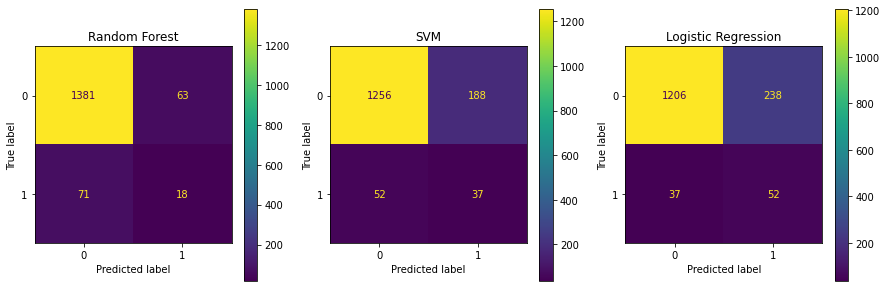

In [95]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 3)

plot = 0
for i in range(1):
    for j in range(3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[i, j])
        plot += 1

plot_confusion_matrix(rf_pipeline, X_test, y_test, ax=ax0)
ax0.set_title('Random Forest')

plot_confusion_matrix(svm_pipeline, X_test, y_test, ax=ax1)
ax1.set_title('SVM')

plot_confusion_matrix(lr_pipeline, X_test, y_test, ax=ax2)
ax2.set_title('Logistic Regression')

plt.show()

As the purpose of this classification task is to predict stroke patient and it is crucial to not miss stroke positive  
patient, LR model seems best suited for this task.

### Parameter tuning

Now let's see if we can have somewhat better result by hyperparameter tuning.

#### Random Forest Classifier

In [96]:
# n_estimators = [75, 100, 125, 150, 200]
# max_features = [2, 4, 6, 8, 10]
# bootstrap = [True, False]
# max_depth = [2, 4, 6, 8, 10, None]
# param_grid = {'n_estimators': n_estimators,
#              'max_features': max_features,
#              'bootstrap': bootstrap,
#              'max_depth': max_depth}

In [97]:
# rfc = RandomForestClassifier()
# gscv_rfc = GridSearchCV(rfc, param_grid)
# gscv_rfc.fit(X_train_res, y_train_res)
# gscv_rfc.best_params_

In [98]:
best_rfc = RandomForestClassifier(n_estimators=150, max_features=5, max_depth=None, bootstrap=True)
ss = StandardScaler()
best_rfc.fit(X_train_res, y_train_res)
best_rfc_pred = best_rfc.predict(X_test)

In [99]:
print(classification_report(y_test, best_rfc_pred))
print('Accuracy Score', accuracy_score(y_test, best_rfc_pred))
print('F1 Score', f1_score(y_test, best_rfc_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1444
           1       0.21      0.19      0.20        89

    accuracy                           0.91      1533
   macro avg       0.58      0.57      0.58      1533
weighted avg       0.91      0.91      0.91      1533

Accuracy Score 0.9106327462491846
F1 Score 0.19883040935672514


Does not show obvious improvement.

Let's have a look at important features from RFC model.

In [100]:
feats = pd.DataFrame({'Features': X_train.columns, 'values': best_rfc.feature_importances_})
feats.sort_values(by='values', ascending=False).reset_index(drop=True).style.background_gradient()

,Features,values
0,age,0.354519
1,avg_glucose_level,0.159316
2,bmi,0.120475
3,age_bin,0.113718
4,smoking_status,0.056041
5,work_type,0.051125
6,gender,0.032277
7,bmi_group,0.027924
8,Residence_type,0.026454
9,ever_married,0.021506


Age showed highest feature importance value from the RFC model.  

#### Logistic Regression

In [101]:
# penalty = ['l1', 'l2']
# C = [0.001, 0.01, 0.1, 1, 10, 100]
# lr_param_grid = {'penalty': penalty, 
#                 'C': C}
# lr = LogisticRegression()
# gscv_lr = GridSearchCV(lr, lr_param_grid)
# gscv_lr.fit(X_train_res, y_train_res)
# gscv_lr.best_params_

In [102]:
best_lr = LogisticRegression(C=0.01, penalty='l2')
best_lr.fit(X_train_res, y_train_res)
best_lr_pred = best_lr.predict(X_test)

In [103]:
print(classification_report(y_test, best_lr_pred))
print('Accuracy Score', accuracy_score(y_test, best_lr_pred))
print('F1 Score', f1_score(y_test, best_lr_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1444
           1       0.18      0.67      0.29        89

    accuracy                           0.80      1533
   macro avg       0.58      0.74      0.59      1533
weighted avg       0.93      0.80      0.85      1533

Accuracy Score 0.8036529680365296
F1 Score 0.2850356294536817


Somewhay improved, but not quite obviously.

#### SVM

In [104]:
# svm_param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#                  'kernel': ['rbf']}
# svm = SVC()
# gscv_svm = GridSearchCV(svm, svm_param_grid)
# gscv_svm.fit(X_train_res, y_train_res)
# gscv_svm.best_params_

In [105]:
best_svm_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                              ('SVM', SVC(C=0.01, gamma=0.1, kernel='rbf'))])
best_svm_pipeline.fit(X_train_res, y_train_res)
best_svm_pred = best_svm_pipeline.predict(X_test)

In [106]:
print(classification_report(y_test, best_svm_pred))
print('Accuracy Score', accuracy_score(y_test, best_svm_pred))
print('F1 Score', f1_score(y_test, best_svm_pred))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1444
           1       0.14      0.52      0.22        89

    accuracy                           0.79      1533
   macro avg       0.55      0.66      0.55      1533
weighted avg       0.92      0.79      0.84      1533

Accuracy Score 0.7912589693411611
F1 Score 0.22330097087378645


### Comparison of models

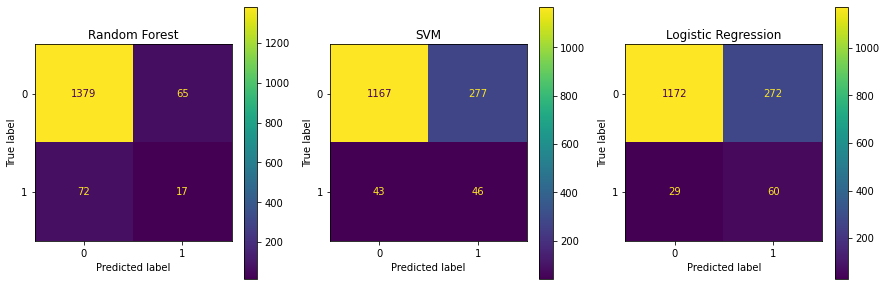

In [107]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(1, 3)

plot = 0
for i in range(1):
    for j in range(3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[i, j])
        plot += 1

ss = StandardScaler()

plot_confusion_matrix(best_rfc, X_test, y_test, ax=ax0)
ax0.set_title('Random Forest')

plot_confusion_matrix(best_svm_pipeline, X_test, y_test, ax=ax1)
ax1.set_title('SVM')

plot_confusion_matrix(best_lr, X_test, y_test, ax=ax2)
ax2.set_title('Logistic Regression')

plt.show()

First, we can see that LR model is best suited for this classification task if we consider that sensitivity might be more important in this task.  
In addition, after the parameter tuning, the result from the LR model showed better sensitivity but also increased false positives.  
In conclusion, RFC has shown best performance at overall accuracy, but LR model is best suited for this classification task.  
And for better performance of model, it seems that we need more samples for the data and other features that can reflect the reality and help prediction of patient at risk of developing stroke.  
Of course, we have other machine learning models to consider for this classification.

### Call of action

Let me summarize.

1. We can see that age is the most important factor for risk of stroke development and we saw that from the result from the RFC.  
   And marital status is also a statistically significant risk factor for developing a stroke.

2. Hypertension, heart disease and glucose group can be a risk factor for developing stroke.

3. Smoking status can be a risk factor for stroke development. And BMI does not seem to be a risk factor for stroke,  
   as opposed to common knowledges. There might be a limitation of this dataset due to small sample size.

4. Even if the overall accuracy of a model is good, that model might not be well suited for a classification task if the dataset is imbalanced and the task needs better sensitivity not accuracy and it is up to us to decide.